<a href="https://colab.research.google.com/github/ericoandre/ericoandre/blob/main/Cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ericoandre/reconhecimento_padroes.git

Cloning into 'reconhecimento_padroes'...
remote: Enumerating objects: 3260, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 3260 (delta 6), reused 7 (delta 2), pack-reused 3249
Receiving objects: 100% (3260/3260), 1.55 GiB | 35.01 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (3669/3669), done.


# Imports

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
import numpy as np
import pandas as pd
from scipy.stats import uniform, randint, expon, loguniform

import cv2
from imutils import paths

import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense
from keras import backend as K
from keras.utils import np_utils
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import Sequential, model_from_json
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, precision_recall_curve, auc, roc_curve

%matplotlib inline

# funcoes

In [ ]:
def loadDataSet_(arg_dataset, myDepth=1):
  print("Path", arg_dataset)
  print("[INFO] loading images...")
  imagePaths = list(paths.list_images(arg_dataset))
  data  = []
  label = []
  
  for imagePath in imagePaths:
    target = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    if(myDepth == 1):
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif myDepth== 0:
      image = np.ravel(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

    data.append(image)
    label.append(target)

  data = np.array(data, dtype="float") / 255.0
  num_classes = len(list(set(label)))
  label_encoder = LabelEncoder()
  labels = label_encoder.fit_transform(label)

  if 1 <= myDepth <=3:
    data = np.array(data).reshape((data.shape[0], data.shape[1], data.shape[2], myDepth))
    labels = np_utils.to_categorical(labels, num_classes)

  return (np.array(data), np.array(labels), label_encoder)

In [ ]:
def modelo_cnn(width, height, depth, optimizer='adam'):
  model = Sequential()
  
  inputShape = (height, width, depth)
  if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
 
  model.add(Conv2D(256, (11, 11), input_shape=inputShape, padding="same", kernel_regularizer=l2(0.0002)))
  model.add(Activation("relu"))
  
  model.add(Conv2D(128, (5, 5), padding="same", kernel_regularizer=l2(0.0002)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (5, 5), padding="same", kernel_regularizer=l2(0.0002)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(32, (3, 3), padding="same", kernel_regularizer=l2(0.0002)))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  
  model.add(Dense(512, kernel_regularizer=l2(0.0002)))
  model.add(Activation("relu"))
  model.add(Dropout(0.12))
  model.add(Dense(len(label_encoder.classes_)))
  model.add(Activation("softmax"))

  loss = 'binary_crossentropy'
  if len(label_encoder.classes_) > 2:
    loss = 'categorical_crossentropy'

  model.compile(loss=loss, optimizer=optimizer,metrics=["accuracy"])
  
  return model

In [ ]:
def cnn_plot(model_cnn, X_teste, y_teste, description):
  y_pred = model_cnn.predict(X_teste)

  acuracia = accuracy_score(y_teste.argmax(axis=1), y_pred)
  precisao = precision_score(y_teste.argmax(axis=1), y_pred)
  cobertura = recall_score(y_teste.argmax(axis=1), y_pred)
  f1_armonica = f1_score(y_teste.argmax(axis=1), y_pred)

  curva_precisao, curva_cobertura, thresholds = precision_recall_curve(y_teste.argmax(axis=1), y_pred)
  auc_precisao_cobertura = auc(curva_cobertura, curva_precisao)

  matrix_confusion = confusion_matrix(y_teste.argmax(axis=1), y_pred)
  #tn, fp, fn, tp = matrix_confusion.ravel()
  fpr, tpr, thresholds = roc_curve(y_teste.argmax(axis=1), y_pred) 

  #scores_dict[description] = [acuracia,auc_precisao_cobertura, precisao,cobertura,f1_armonica, (tn, fp, fn, tp)]

  # imprimindo
  print('----- ------------------------- -----')
  print("Acurácia de teste = {:.3f}".format(acuracia))
  print("AUC = {:.3f}".format(auc_precisao_cobertura))
  print("Precisão = {:.3f}, cobertura = {:.3f}".format(precisao, cobertura))
  print("F1 = {:.3f}".format(f1_armonica))
  print('----- ------------------------- -----')

  fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
  fig.suptitle(description) # "CNN"

  sns.heatmap(matrix_confusion,annot=True, fmt='g', linewidth=0.3,cbar=True, ax=axes[0]) # ,xticklabels=classes_label, yticklabels=classes_label
      
  axes[0].annotate('VN', (0.3,0.5), fontweight='bold')
  axes[0].annotate('FP', (1.3,0.5), fontweight='bold')
  axes[0].annotate('FN', (0.3,1.5), fontweight='bold')
  axes[0].annotate('VP', (1.3,1.5), fontweight='bold')

  axes[1].plot(curva_cobertura, curva_precisao)
  axes[1].set_xlabel('')
  axes[1].set_ylabel('')

  axes[2].plot(fpr, tpr)
  axes[2].plot([0, 1], ls="--")
  axes[2].plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  axes[2].set_xlabel('True Positive Rate')
  axes[2].set_ylabel('False Positive Rate')
  plt.show()

# Atributos

In [ ]:
sns.set()

#Atributos
seed = 42
largura=200
altura=267
teste_size=0.3

arg_epochs = 20
custon_batch_size = 32
custon_depth= 3

np.random.seed(seed)

In [ ]:
arg_dataset = "reconhecimento_padroes/imagens_aumentada_mascara{}x{}".format(largura, altura)
X_cnn, Y_cnn, label_encoder = loadDataSet_(arg_dataset, custon_depth)

X_treino_cnn, X_teste_cnn, y_treino_cnn, y_teste_cnn = train_test_split(X_cnn, Y_cnn, test_size=teste_size, random_state=seed)

Path reconhecimento_padroes/imagens_aumentada_mascara200x267
[INFO] loading images...


In [ ]:
my_param_grid = {
  'epochs': [10],
  'batch_size' : [16, 32],
  'optimizer': ['adam', 'gdm']
}

modelo = KerasClassifier(build_fn=modelo_cnn, width=largura, height=altura, depth=custon_depth, verbose=1)

kfold = KFold(n_splits=2, shuffle=True, random_state = seed)

griglia = RandomizedSearchCV(estimator=modelo, param_distributions=my_param_grid, cv=kfold, n_iter=3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 2 is smaller than n_iter=3. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Epoch 1/10
30/30 [==============================] - 59s 1s/step - loss: 0.9448 - accuracy: 0.5708
Epoch 2/10
30/30 [==============================] - 30s 1s/step - loss: 0.8559 - accuracy: 0.6875
Epoch 3/10
30/30 [==============================] - 30s 1s/step - loss: 0.8227 - accuracy: 0.6979
Epoch 4/10
30/30 [==============================] - 30s 1s/step - loss: 0.6024 - accuracy: 0.8354
Epoch 5/10
30/30 [==============================] - 30s 1s/step - loss: 0.4559 - accuracy: 0.9125
Epoch 6/10
30/30 [==============================] - 30s 1s/step - loss: 0.4323 - accuracy: 0.9104
Epoch 7/10
30/30 [==============================] - 30s 1s/step - loss: 0.3375 - accuracy: 0.9438
Epoch 8/10
30/30 [==============================] - 30s 1s/step - loss: 0.2908 - accuracy: 0.9667
Epoch 9/10
30/30 [==============================] - 30s 1s/step - loss: 0.2492 - accuracy: 0.9833
Epoch 10/10
31/31 [==============================] - 11s 341ms/step - loss: 0.8950 - accuracy: 0.8607
Epoch 1/10
31/31

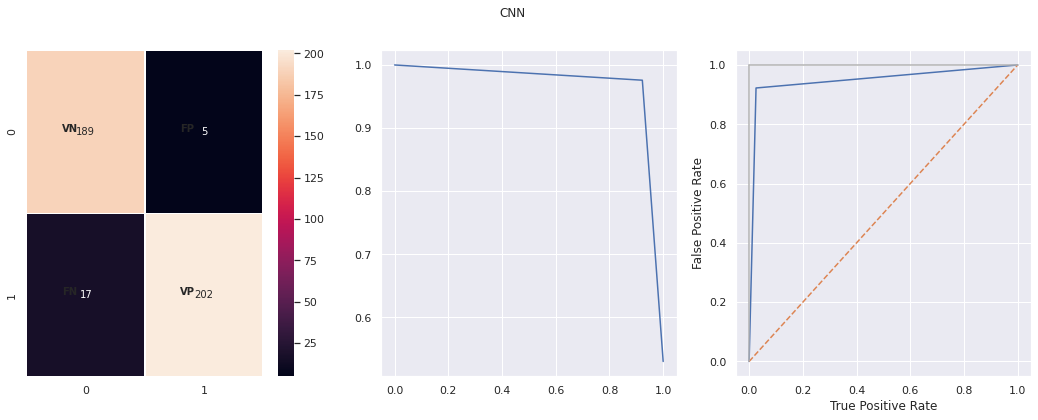

In [ ]:
best_model = griglia.fit(X_treino_cnn, y_treino_cnn)

pred_yfit = best_model.predict(X_teste_cnn)

description = "CNN"
# print(gaussian_best_model.best_estimator_)
print("[INFO] {} ... Best params: {}\n".format(description, best_model.best_params_))
print('----- Evaluation on Test Data -----')
print(classification_report(y_teste_cnn.argmax(axis=1), pred_yfit))
cnn_plot(best_model, X_teste_cnn, y_teste_cnn, description)

In [ ]:
#   optimizer = Adam(learning_rate=1e-4, decay=1e-4 / epochs)